# Welcome to: Demagnetization estimation with Machine Learning techniques
This project was made by Jacopo Ferretti for for the exam of Machine Learning.

## What is the goal?
For this project, I will be trying to predict the Overload Magnetization limit for a Surface Permanent Magnet Motor using Machine Learning techniques.

More info and a detailed explanation on how dataset is obtained can be find in the report available in this same repository.

### Why it can be interesting?
As discussed on the report, high performance electric motors are exploiting a lot their overload capabilities, but if design is not well made, demagnetization could happen ad high current.

Although demagnetization is a well known phenomenon, this is difficult to predict, in particular for fractional winding stator configuration.

In [24]:
# Only for Google Colab
from google.colab import drive
drive.mount('/content/drive')
! cp /content/drive/MyDrive/Dataset_SPM_demagnetization.csv ./DatasetSPM.csv
! ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DatasetSPM.csv	drive  sample_data


In [25]:
# importing some libraries
import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
plt.style.use('bmh')

df = pd.read_csv('./DatasetSPM.csv')
df.shape

(7000, 12)

#### Features and their range:
- Nominal Torque: 150 N m ± 75 N m
- Rated Speed: 3.5 krpm ± 1.75 krpm
- Magnetic Loading: 0.75 T ± 0.375 T
- Electric Loading: 4 kA/m ± 2 kA/m
- Aspect Ratio: 1.5 ± 0.75
- Slot Opening: 5 mm ± 1.75 mm
- Airgap Thikness: 1.2 mm ± 0.42 mm
- Magnet height: lmagn0 (from calculation) | range-> lmagn0 ∗ 1.5 ± lmagn0 ∗ 0.1
- Slot Opening height: 2 mm ± 0.7 mm
- Wedge Height: 5 mm ± 1.75 mm

#### Label:
- Overload: 0 to 11

0 -> No overload capability<br />
11-> 6.5 overload capability

#### From label to OL capability:<br />
``OL=(Label/2)+1``

In [26]:
# some info about Dataset and TensorFlow
print(os.listdir("./"))
print('TensorFlow Version:', tf.__version__)
df.info()
df.describe().T

['.config', 'DatasetSPM.csv', 'drive', 'sample_data']
TensorFlow Version: 2.9.2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   T_spec             7000 non-null   float64
 1   Rated_speed_spec   7000 non-null   float64
 2   Bmr                7000 non-null   float64
 3   delta              7000 non-null   float64
 4   m                  7000 non-null   float64
 5   so                 7000 non-null   float64
 6   d0                 7000 non-null   float64
 7   Lmagn              7000 non-null   float64
 8   h4                 7000 non-null   float64
 9   h3                 7000 non-null   float64
 10  max_OL             7000 non-null   int64  
 11  max_OL_analytical  7000 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 656.4 KB


count          mean          std           min  \
T_spec             7000.0    148.937762    43.547482     75.019882   
Rated_speed_spec   7000.0   3495.823798  1000.553744   1750.311556   
Bmr                7000.0      0.873420     0.199633      0.447169   
delta              7000.0  32894.564865  9262.622212  14562.363585   
m                  7000.0      1.497412     0.434351      0.750599   
so                 7000.0      0.004963     0.001009      0.003250   
d0                 7000.0      0.001202     0.000244      0.000780   
Lmagn              7000.0      3.332968     2.525963      0.428287   
h4                 7000.0      0.002008     0.000405      0.001300   
h3                 7000.0      0.002965     0.000606      0.001950   
max_OL             7000.0      3.158143     3.399611      0.000000   
max_OL_analytical  7000.0      3.925496     4.542423      0.000239   

                            25%           50%           75%           max  
T_spec               110.953021    148.565816    187.111198    224.961231  
Rated_speed_spec    2632.206629   3480.947110   4369.655153   5249.273976  
Bmr                    0.705492      0.888258      1.048371      1.200657  
delta              25039.978854  32926.312825  40378.390096  55433.235605  
m                      1.119684      1.502527      1.869365      2.249956  
so                     0.004082      0.004975      0.005823      0.006749  
d0                     0.000991      0.001203      0.001415      0.001620  
Lmagn                  1.395118      2.489015      4.599695     15.323852  
h4                     0.001651      0.002017      0.002356      0.002700  
h3                     0.002438      0.002942      0.003493      0.004050  
max_OL                 0.000000      2.000000      5.000000     11.000000  
max_OL_analytical      0.715458      2.106228      5.666880     33.166976

In [27]:
# preliminary check if there is any null values
df.isnull().values.any()
nans=pd.isnull(df).sum()
nans[nans>0]
print(df.isnull().values.any())
print(nans)

False
T_spec               0
Rated_speed_spec     0
Bmr                  0
delta                0
m                    0
so                   0
d0                   0
Lmagn                0
h4                   0
h3                   0
max_OL               0
max_OL_analytical    0
dtype: int64


In [28]:
# Drop analytical demagnetization result (will be used later)
test_labels_analytical = df.max_OL[:]
predictions_analytical = df.max_OL_analytical[:]

df = df.drop(columns=['max_OL_analytical'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   T_spec            7000 non-null   float64
 1   Rated_speed_spec  7000 non-null   float64
 2   Bmr               7000 non-null   float64
 3   delta             7000 non-null   float64
 4   m                 7000 non-null   float64
 5   so                7000 non-null   float64
 6   d0                7000 non-null   float64
 7   Lmagn             7000 non-null   float64
 8   h4                7000 non-null   float64
 9   h3                7000 non-null   float64
 10  max_OL            7000 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 601.7 KB


<ipython-input-29-51f1617e622f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfui['max_OL_analytical'] = predictions_analytical


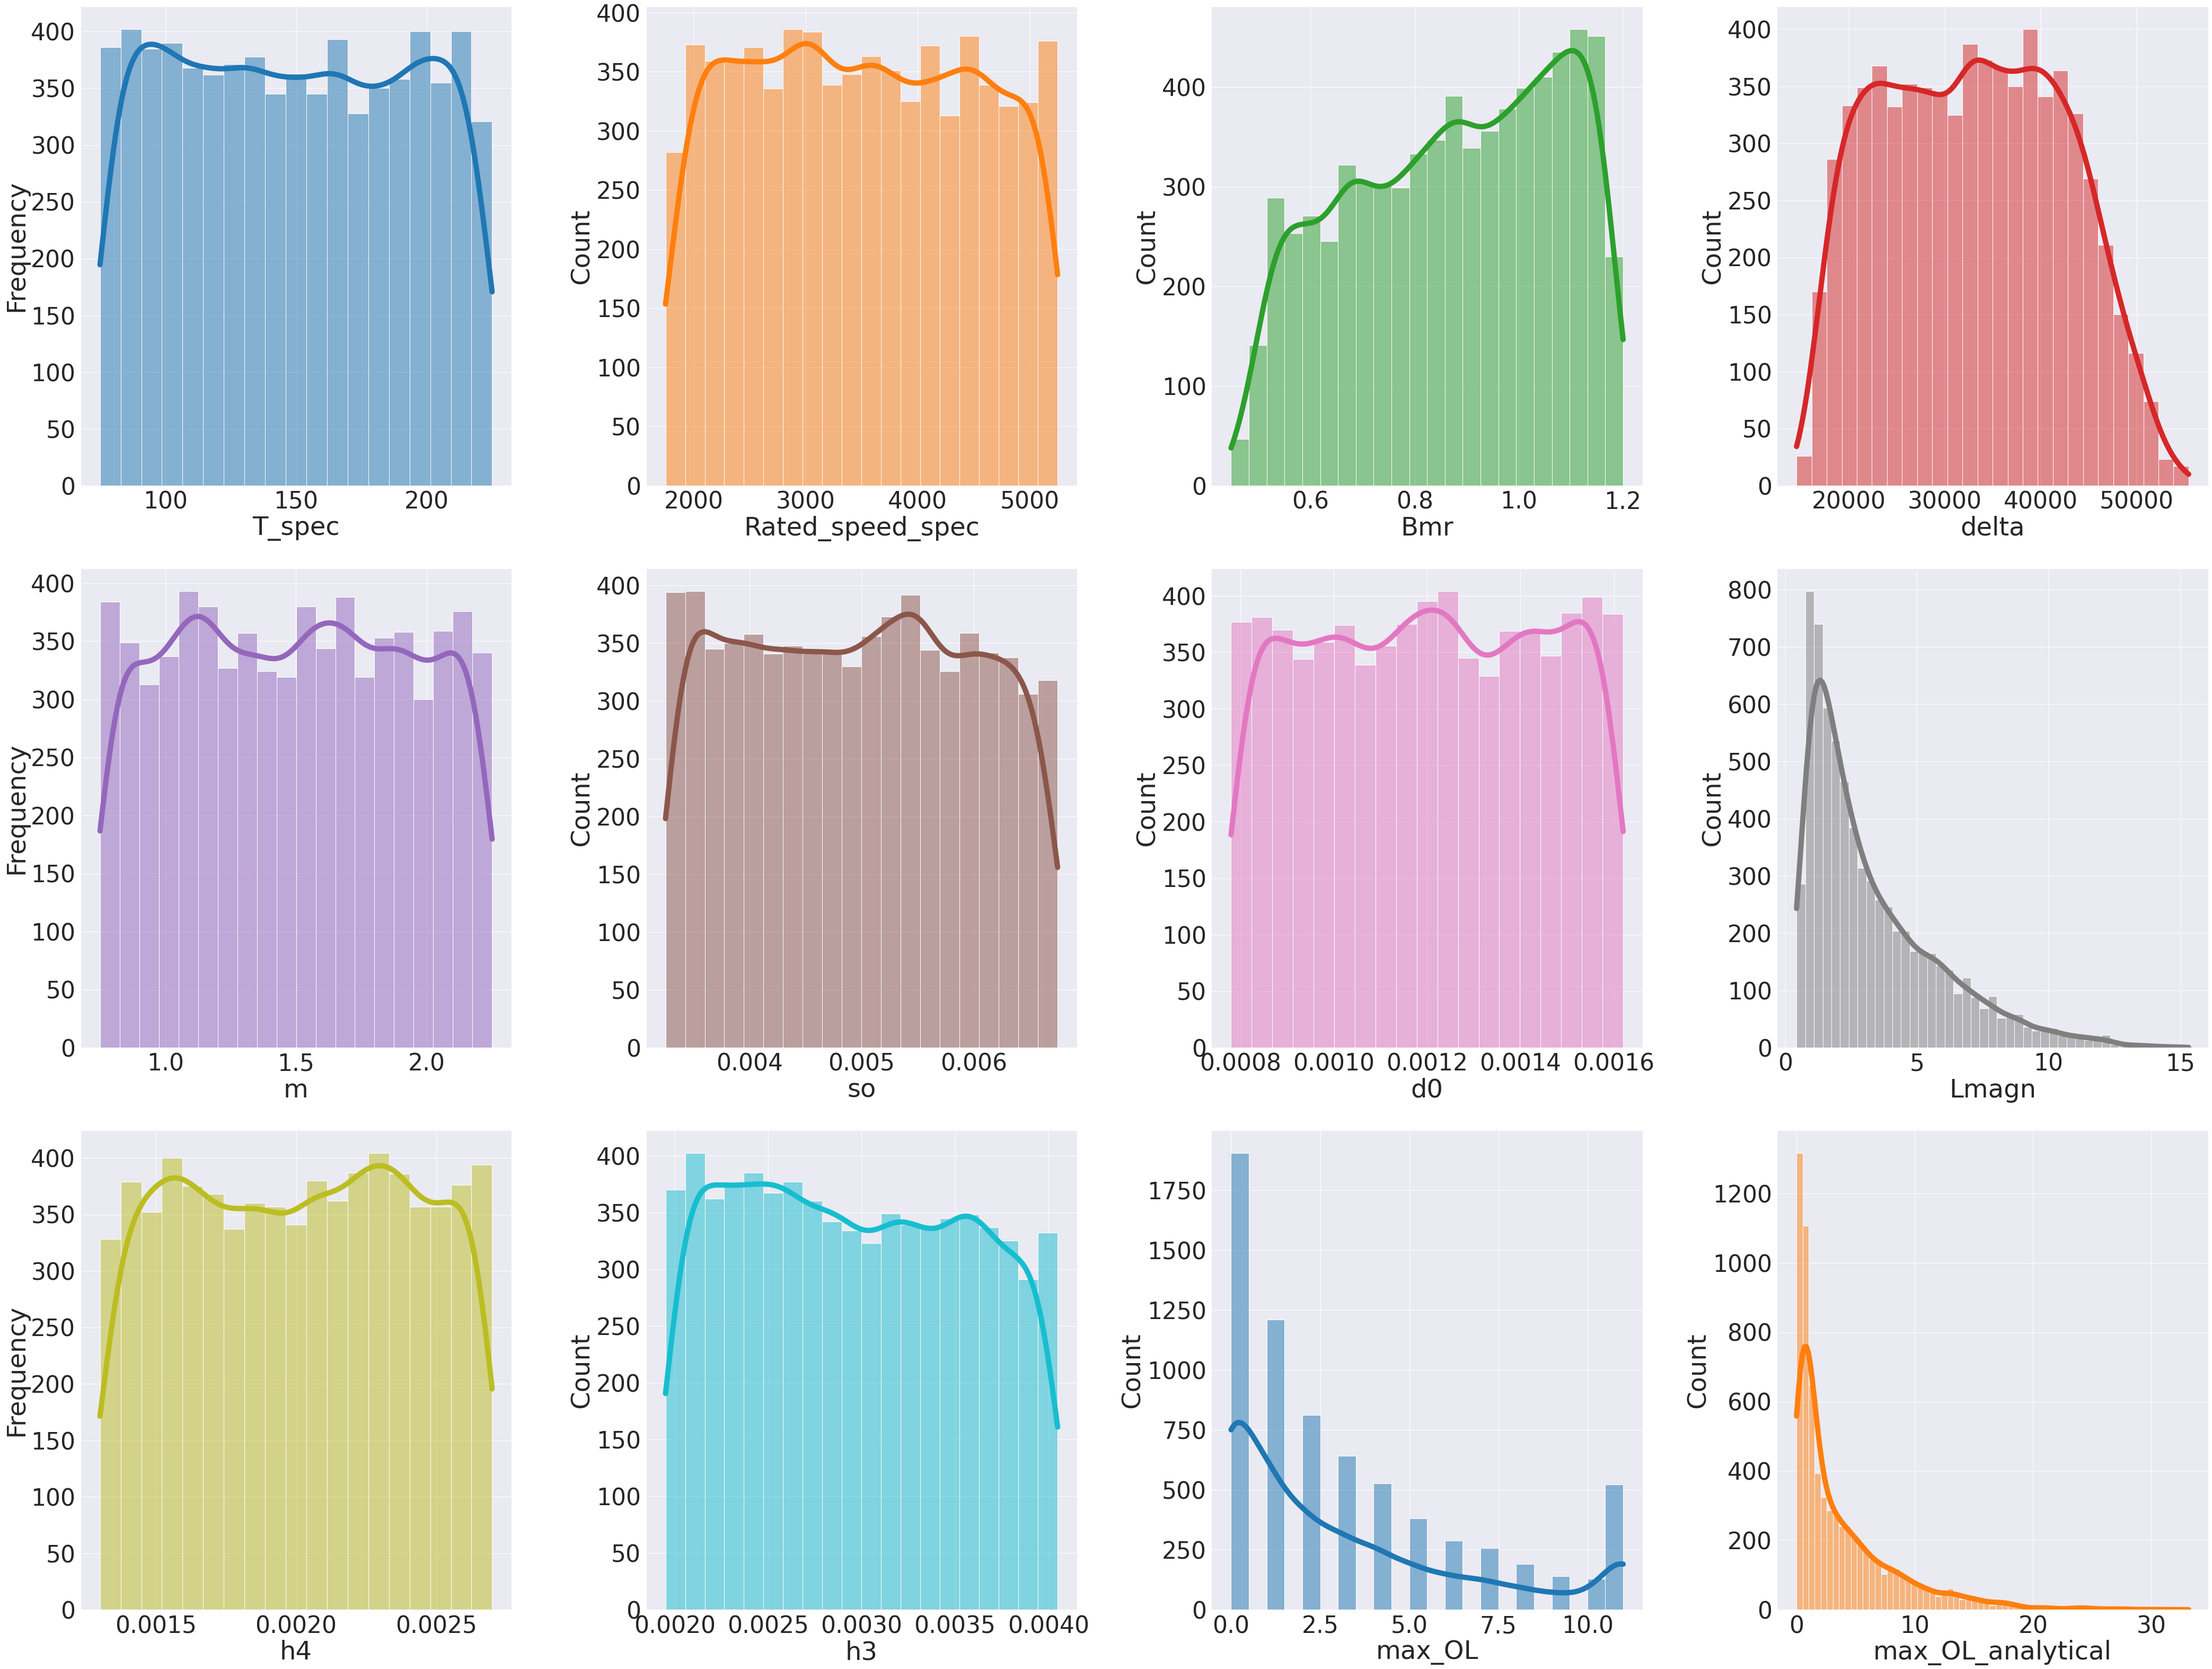

In [29]:
# Some plot about the Dataset
dfui = df[:]
dfui['max_OL_analytical'] = predictions_analytical

color_list = plt.cm.tab10(np.linspace(0, 1, 10)[list(range(10))+[0, 1]]) # prepare colors
coi = [c for c in dfui]  # columns of interest

feat_clrs = {k: rgb2hex(color_list[i][:3]) for i, k in enumerate(coi)} if color_list is not None else {}

n_cols = 4
n_rows = np.ceil(dfui.shape[1] / n_cols).astype(int)
sns.set(font_scale=4)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14.8*n_cols, n_rows*15))
for i, (ax, col) in enumerate(zip(axes.flatten(), list(dfui.columns))):
    sns.histplot(dfui[col], color=feat_clrs[col], ax=ax,kde=True,line_kws={"lw":10})
    if i % n_cols == 0:
        ax.set_ylabel('Frequency')
       
plt.tight_layout()

In [30]:
# FOR INLINE PLOT -> Figsize=[12,12] ; Font_scale = 1
# FOR SAVING PLOT -> Figsize=[60,60] ; Font_scale = 5
Figsize = [12,12]
Font_scale = 1

<ipython-input-31-4effa8996d5a>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask= np.zeros_like(corr,dtype=np.bool),


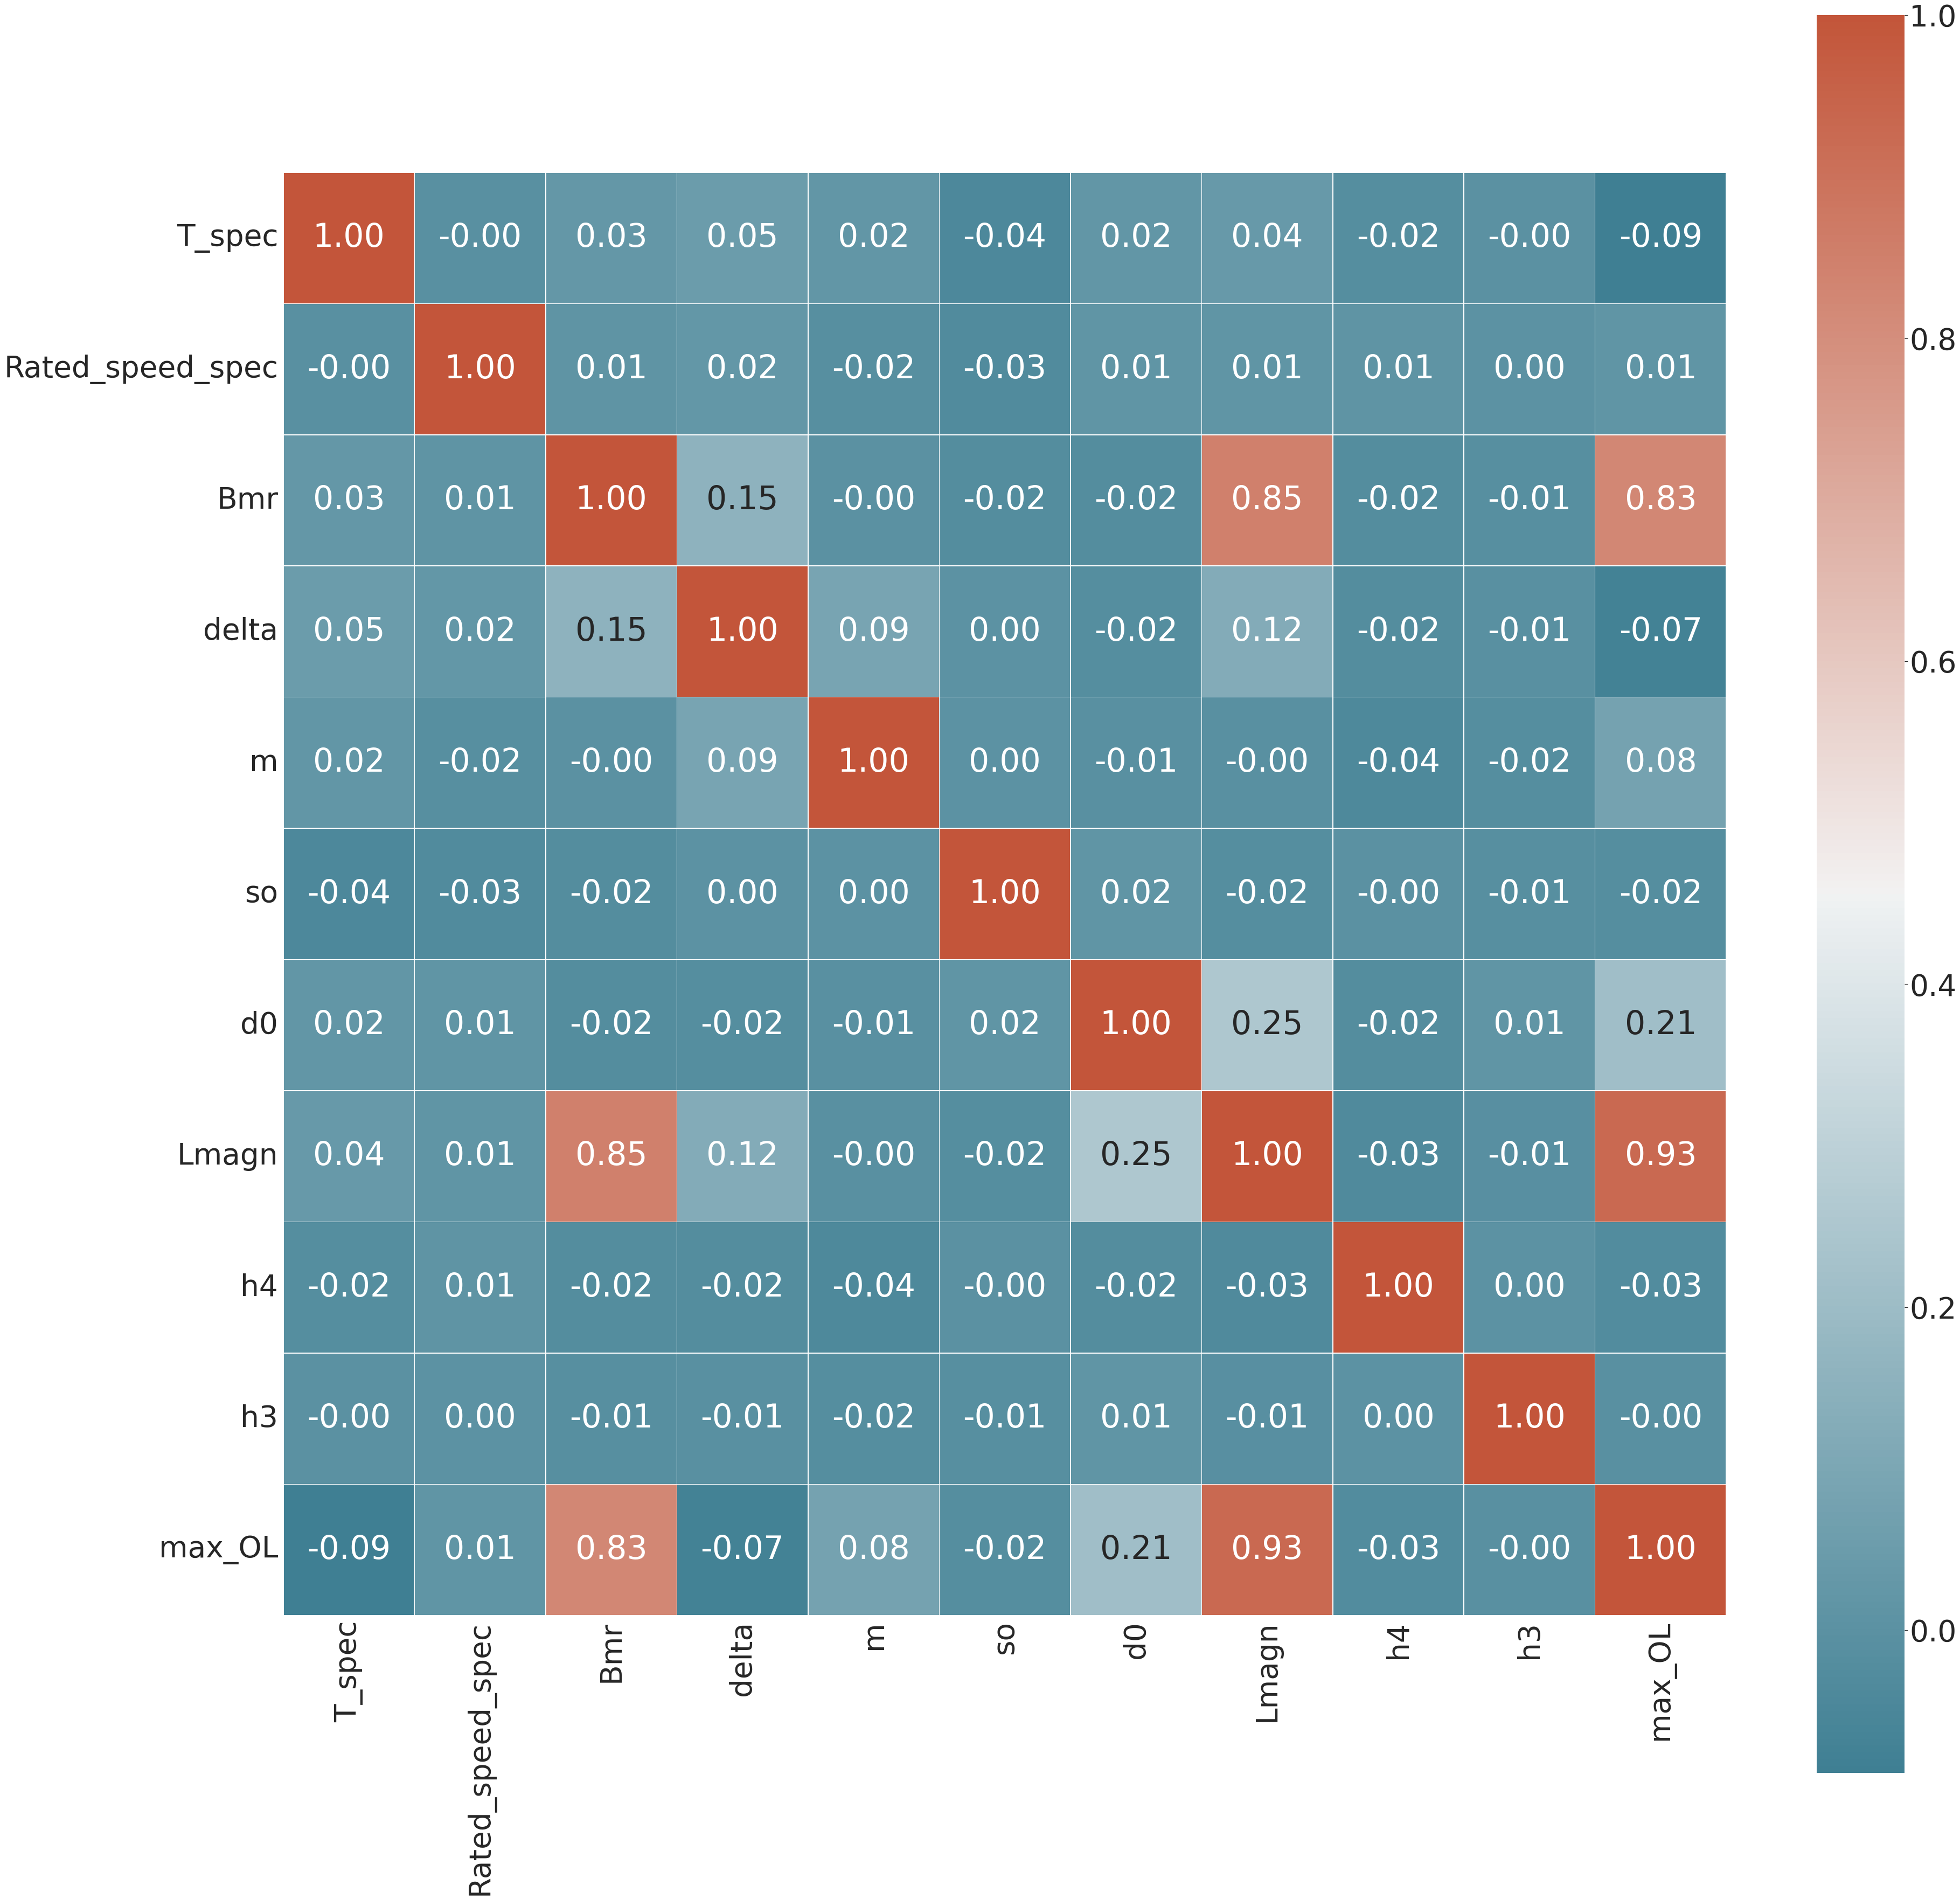

In [31]:
#correlation map
sns.set(font_scale=Font_scale)
f,ax=plt.subplots(figsize=Figsize)
corr=df.corr()


sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f',
            mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=sns.diverging_palette(220, 20, as_cmap=True), 
            square=True, ax=ax)

plt.show()

From the correlation map, it can be seen that magnet height ``Lmagn`` and magnetic loading ``Bmr`` are highly correlated with the maximum overload ``max_OL`` 

In [32]:
# Normalization of the dataset
dff = df.drop(columns=['max_OL'])
coi = [c for c in dff]
dff.describe().T
for i in range(len(coi)):
  df[coi[i]] = df[coi[i]]-min(df[coi[i]])
  df[coi[i]] = df[coi[i]]/max(df[coi[i]])
df.describe().T

count      mean       std  min       25%       50%  \
T_spec            7000.0  0.492979  0.290430  0.0  0.239648  0.490498   
Rated_speed_spec  7000.0  0.498866  0.285957  0.0  0.252045  0.494614   
Bmr               7000.0  0.565704  0.264946  0.0  0.342836  0.585395   
delta             7000.0  0.448540  0.226631  0.0  0.256359  0.449316   
m                 7000.0  0.498088  0.289692  0.0  0.246162  0.501500   
so                7000.0  0.489536  0.288350  0.0  0.237801  0.492866   
d0                7000.0  0.502532  0.290337  0.0  0.251272  0.503282   
Lmagn             7000.0  0.195003  0.169578  0.0  0.064907  0.138345   
h4                7000.0  0.505373  0.288976  0.0  0.250614  0.512253   
h3                7000.0  0.483389  0.288813  0.0  0.232178  0.472476   
max_OL            7000.0  3.158143  3.399611  0.0  0.000000  2.000000   

                       75%   max  
T_spec            0.747568   1.0  
Rated_speed_spec  0.748606   1.0  
Bmr               0.797892   1.0  
delta             0.631649   1.0  
m                 0.746164   1.0  
so                0.735225   1.0  
d0                0.755929   1.0  
Lmagn             0.280044   1.0  
h4                0.754037   1.0  
h3                0.734963   1.0  
max_OL            5.000000  11.0

In [33]:
# Dataset split in train and test set
# train, test = train_test_split(df, test_size=0.2)
train, test = train_test_split(df, test_size=0.2, random_state=5, stratify=df['max_OL'])
train, val  = train_test_split(train, test_size=0.1, random_state=5, stratify=train['max_OL'])

In [34]:
# Separation Features from label
train_data = train.drop(columns=['max_OL'])
train_data.reset_index()
train_labels = train['max_OL']
train_labels.reset_index()

print('Train_data shape:', train_data.shape)
print('Train_labels shape:', train_labels.shape)


test_data = test.drop(columns=['max_OL'])
test_data.reset_index()
test_labels = test['max_OL']
test_labels.reset_index()

print('Test_data shape:', test_data.shape)
print('Test_labels shape:', test_labels.shape)


val_data = val.drop(columns=['max_OL'])
val_data.reset_index()
val_labels = val['max_OL']
val_labels.reset_index()

print('Val_data shape:', val_data.shape)
print('Val_labels shape:', val_labels.shape)



for i in range(10):
  print('motor n.', i ,' ->',train_labels.values[i])

Train_data shape: (5040, 10)
Train_labels shape: (5040,)
Test_data shape: (1400, 10)
Test_labels shape: (1400,)
Val_data shape: (560, 10)
Val_labels shape: (560,)
motor n. 0  -> 1
motor n. 1  -> 2
motor n. 2  -> 1
motor n. 3  -> 0
motor n. 4  -> 0
motor n. 5  -> 1
motor n. 6  -> 9
motor n. 7  -> 5
motor n. 8  -> 1
motor n. 9  -> 0


In [35]:
def plot_regression_result_lmagn(x, y):
  # plt.figure(dpi=800)
  plt.scatter(train_data['Lmagn'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.ylim([0, 12])
  plt.xlim([0, 1])
  plt.xlabel('Lmagn')
  plt.ylabel('OL')
  plt.legend()

def plot_regression_result_Bmr(x, y):
  # plt.figure(dpi=800)
  plt.scatter(train_data['Bmr'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.ylim([0, 12])
  plt.xlim([0, 1.1])
  plt.xlabel('Bmr')
  plt.ylabel('OL')
  plt.legend()

def plot_loss(history):
  # plt.figure(dpi=800)
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0,inf])
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)

n_epochs = 150

################################################################################
#### Linear regression model
- one variable ``Lmagn``

In [36]:
tf.keras.backend.clear_session()
linear_reg_monovariable_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1,1)),
    tf.keras.layers.Dense(units=1)
])
linear_reg_monovariable_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [37]:

linear_reg_monovariable_model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['accuracy'])

history = linear_reg_monovariable_model.fit(
    train_data['Lmagn'],
    train_labels,
    epochs=n_epochs,
    validation_data=(val_data['Lmagn'],val_labels))

Epoch 1/150
158/158 [==============================] - 3s 4ms/step - loss: 3.2298 - accuracy: 0.2718 - val_loss: 3.1893 - val_accuracy: 0.2714
Epoch 2/150
158/158 [==============================] - 0s 3ms/step - loss: 3.1473 - accuracy: 0.2718 - val_loss: 3.1053 - val_accuracy: 0.2714
Epoch 3/150
158/158 [==============================] - 0s 3ms/step - loss: 3.0606 - accuracy: 0.2718 - val_loss: 3.0172 - val_accuracy: 0.2714
Epoch 4/150
158/158 [==============================] - 0s 3ms/step - loss: 2.9708 - accuracy: 0.2526 - val_loss: 2.9266 - val_accuracy: 0.1732
Epoch 5/150
158/158 [==============================] - 0s 3ms/step - loss: 2.8796 - accuracy: 0.1730 - val_loss: 2.8345 - val_accuracy: 0.1732
Epoch 6/150
158/158 [==============================] - 0s 3ms/step - loss: 2.7877 - accuracy: 0.1730 - val_loss: 2.7426 - val_accuracy: 0.1732
Epoch 7/150
158/158 [==============================] - 0s 3ms/step - loss: 2.6951 - accuracy: 0.1730 - val_loss: 2.6523 - val_accuracy: 0.1732

In [38]:
val_loss, val_acc = linear_reg_monovariable_model.evaluate(val_data['Lmagn'],  val_labels, verbose=2)

print('\nTest accuracy:', val_acc)

18/18 - 0s - loss: 0.8425 - accuracy: 0.3482 - 44ms/epoch - 2ms/step

Test accuracy: 0.3482142984867096


7/7 [==============================] - 0s 2ms/step


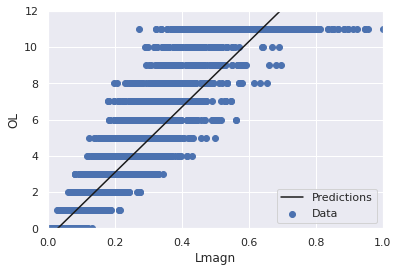

In [39]:
x = tf.linspace(0.0, 1, 200)
y = linear_reg_monovariable_model.predict(x)

sns.set(font_scale=1)
plot_regression_result_lmagn(x, y)

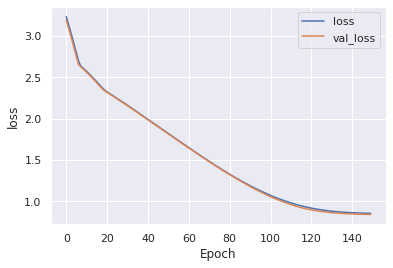

In [40]:
plot_loss(history)

################################################################################
#### Linear regression model
- Multiple variable

In [41]:
tf.keras.backend.clear_session()
linear_reg_multivariable_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,1)),
    tf.keras.layers.Dense(units=1)
])
linear_reg_multivariable_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [42]:

linear_reg_multivariable_model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['accuracy'])

history = linear_reg_multivariable_model.fit(
    train_data,
    train_labels,
    epochs=n_epochs,
    validation_data=(val_data,val_labels))

Epoch 1/150
158/158 [==============================] - 1s 3ms/step - loss: 3.3972 - accuracy: 0.2732 - val_loss: 3.0702 - val_accuracy: 0.2768
Epoch 2/150
158/158 [==============================] - 0s 3ms/step - loss: 2.8482 - accuracy: 0.2540 - val_loss: 2.7108 - val_accuracy: 0.2250
Epoch 3/150
158/158 [==============================] - 0s 3ms/step - loss: 2.5940 - accuracy: 0.2139 - val_loss: 2.5364 - val_accuracy: 0.1857
Epoch 4/150
158/158 [==============================] - 0s 3ms/step - loss: 2.4727 - accuracy: 0.1853 - val_loss: 2.4466 - val_accuracy: 0.1732
Epoch 5/150
158/158 [==============================] - 0s 3ms/step - loss: 2.4049 - accuracy: 0.1772 - val_loss: 2.3866 - val_accuracy: 0.1732
Epoch 6/150
158/158 [==============================] - 0s 3ms/step - loss: 2.3575 - accuracy: 0.1748 - val_loss: 2.3395 - val_accuracy: 0.1732
Epoch 7/150
158/158 [==============================] - 0s 3ms/step - loss: 2.3171 - accuracy: 0.1736 - val_loss: 2.2978 - val_accuracy: 0.1732

In [43]:
val_loss, val_acc = linear_reg_multivariable_model.evaluate(val_data,  val_labels, verbose=2)

print('\nTest accuracy:', val_acc)

18/18 - 0s - loss: 0.6756 - accuracy: 0.4089 - 44ms/epoch - 2ms/step

Test accuracy: 0.4089285731315613


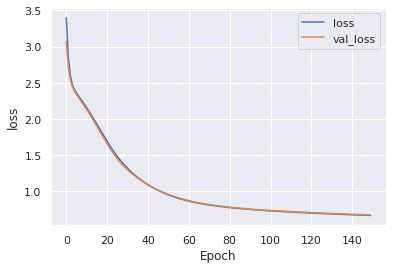

In [44]:
plot_loss(history)

################################################################################
#### NON Linear regression model (DNN)
- one variable ``Lmagn``

In [45]:
tf.keras.backend.clear_session()
dnn_reg_monovariable_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1,1)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
dnn_reg_monovariable_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [46]:
dnn_reg_monovariable_model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['accuracy'])

history = dnn_reg_monovariable_model.fit(
    train_data['Lmagn'],
    train_labels,
    epochs=n_epochs,
    validation_data=(val_data['Lmagn'],val_labels))

Epoch 1/150
158/158 [==============================] - 1s 4ms/step - loss: 1.6753 - accuracy: 0.2698 - val_loss: 0.8216 - val_accuracy: 0.3607
Epoch 2/150
158/158 [==============================] - 0s 3ms/step - loss: 0.8243 - accuracy: 0.3591 - val_loss: 0.8163 - val_accuracy: 0.3554
Epoch 3/150
158/158 [==============================] - 0s 3ms/step - loss: 0.8227 - accuracy: 0.3613 - val_loss: 0.8032 - val_accuracy: 0.3536
Epoch 4/150
158/158 [==============================] - 0s 3ms/step - loss: 0.8145 - accuracy: 0.3605 - val_loss: 0.8239 - val_accuracy: 0.3589
Epoch 5/150
158/158 [==============================] - 1s 3ms/step - loss: 0.8141 - accuracy: 0.3641 - val_loss: 0.8181 - val_accuracy: 0.3571
Epoch 6/150
158/158 [==============================] - 1s 3ms/step - loss: 0.8112 - accuracy: 0.3659 - val_loss: 0.8035 - val_accuracy: 0.3554
Epoch 7/150
158/158 [==============================] - 0s 3ms/step - loss: 0.8087 - accuracy: 0.3591 - val_loss: 0.8085 - val_accuracy: 0.3589

18/18 - 0s - loss: 0.7681 - accuracy: 0.3518 - 45ms/epoch - 3ms/step

Test accuracy: 0.35178571939468384


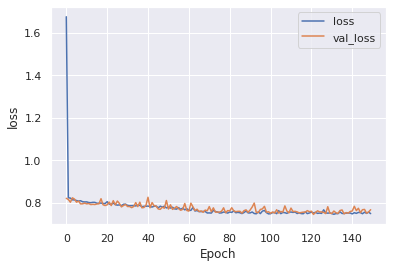

In [47]:
val_loss, val_acc = dnn_reg_monovariable_model.evaluate(val_data['Lmagn'],  val_labels, verbose=2)

print('\nTest accuracy:', val_acc)
plot_loss(history)

63/63 [==============================] - 0s 1ms/step


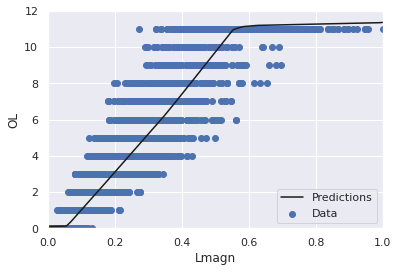

In [48]:
x = tf.linspace(0.0, 1, 2000)
y = dnn_reg_monovariable_model.predict(x)


plot_regression_result_lmagn(x, y)

################################################################################
#### NON Linear regression model (DNN)
- one variable ``Bmr``

In [73]:
tf.keras.backend.clear_session()
dnn_reg_monovariable_model_Bmr = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1,1)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
dnn_reg_monovariable_model_Bmr.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [74]:
dnn_reg_monovariable_model_Bmr.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['accuracy'])

history = dnn_reg_monovariable_model_Bmr.fit(
    train_data['Bmr'],
    train_labels,
    epochs=n_epochs,
    validation_data=(val_data['Bmr'],val_labels))

Epoch 1/150
158/158 [==============================] - 1s 4ms/step - loss: 1.9063 - accuracy: 0.2633 - val_loss: 1.2210 - val_accuracy: 0.3375
Epoch 2/150
158/158 [==============================] - 0s 3ms/step - loss: 1.1618 - accuracy: 0.3409 - val_loss: 1.1077 - val_accuracy: 0.3411
Epoch 3/150
158/158 [==============================] - 1s 3ms/step - loss: 1.1023 - accuracy: 0.3393 - val_loss: 1.0449 - val_accuracy: 0.3339
Epoch 4/150
158/158 [==============================] - 0s 3ms/step - loss: 1.0538 - accuracy: 0.3413 - val_loss: 1.0234 - val_accuracy: 0.3393
Epoch 5/150
158/158 [==============================] - 1s 3ms/step - loss: 1.0303 - accuracy: 0.3415 - val_loss: 0.9977 - val_accuracy: 0.3393
Epoch 6/150
158/158 [==============================] - 1s 3ms/step - loss: 1.0232 - accuracy: 0.3399 - val_loss: 1.0110 - val_accuracy: 0.3393
Epoch 7/150
158/158 [==============================] - 0s 3ms/step - loss: 1.0196 - accuracy: 0.3413 - val_loss: 0.9877 - val_accuracy: 0.3393

18/18 - 0s - loss: 1.0235 - accuracy: 0.3357 - 47ms/epoch - 3ms/step

Test accuracy: 0.33571428060531616


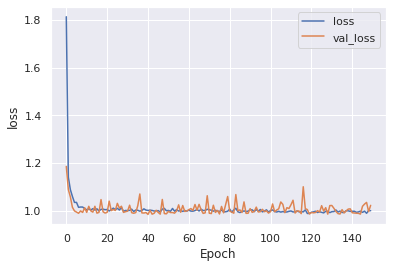

In [51]:
val_loss, val_acc = dnn_reg_monovariable_model_Bmr.evaluate(val_data['Bmr'],  val_labels, verbose=2)

print('\nTest accuracy:', val_acc)
plot_loss(history)

63/63 [==============================] - 0s 1ms/step


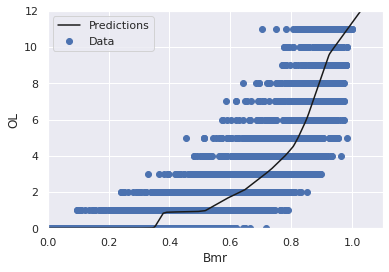

In [52]:
x = tf.linspace(0.0, 1.1, 2000)
y = dnn_reg_monovariable_model_Bmr.predict(x)


plot_regression_result_Bmr(x, y)

################################################################################
#### NON Linear regression model (DNN)
- Multiple variable

In [53]:
tf.keras.backend.clear_session()
dnn_reg_multivariable_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,1)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])
dnn_reg_multivariable_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 44,065
Trainable params: 44,065
Non-traina

In [54]:
dnn_reg_multivariable_model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['accuracy'])

history = dnn_reg_multivariable_model.fit(
    train_data,
    train_labels,
    epochs=n_epochs,
    validation_data=(val_data,val_labels))

Epoch 1/150
158/158 [==============================] - 1s 4ms/step - loss: 1.1798 - accuracy: 0.3236 - val_loss: 0.4986 - val_accuracy: 0.3893
Epoch 2/150
158/158 [==============================] - 0s 3ms/step - loss: 0.4439 - accuracy: 0.4071 - val_loss: 0.4161 - val_accuracy: 0.4018
Epoch 3/150
158/158 [==============================] - 1s 3ms/step - loss: 0.4070 - accuracy: 0.4085 - val_loss: 0.3643 - val_accuracy: 0.4054
Epoch 4/150
158/158 [==============================] - 1s 3ms/step - loss: 0.3720 - accuracy: 0.4117 - val_loss: 0.3644 - val_accuracy: 0.4036
Epoch 5/150
158/158 [==============================] - 1s 4ms/step - loss: 0.3472 - accuracy: 0.4133 - val_loss: 0.3331 - val_accuracy: 0.4107
Epoch 6/150
158/158 [==============================] - 1s 3ms/step - loss: 0.3359 - accuracy: 0.4137 - val_loss: 0.3241 - val_accuracy: 0.4071
Epoch 7/150
158/158 [==============================] - 1s 3ms/step - loss: 0.3368 - accuracy: 0.4125 - val_loss: 0.3119 - val_accuracy: 0.4089

18/18 - 0s - loss: 0.1590 - accuracy: 0.4339 - 48ms/epoch - 3ms/step

Test accuracy: 0.43392857909202576


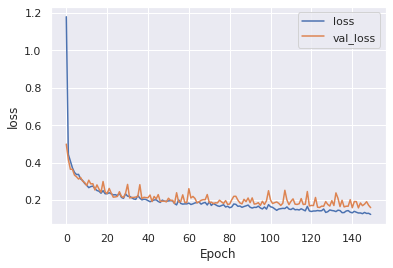

In [55]:
val_loss, val_acc = dnn_reg_multivariable_model.evaluate(val_data,  val_labels, verbose=2)

print('\nTest accuracy:', val_acc)

plot_loss(history)

################################################################################
#### DNN classification model
- Multiple Variable

In [56]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,1)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(12)
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 12)                3084      
                                                                 
Total params: 46,892
Trainable params: 46,892
Non-traina

In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(),#learning_rate=0.0024),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data, 
                           train_labels, 
                           epochs=n_epochs,
                           validation_data=(val_data,val_labels))


Epoch 1/150
158/158 [==============================] - 1s 4ms/step - loss: 1.5835 - accuracy: 0.4421 - val_loss: 0.8822 - val_accuracy: 0.6518
Epoch 2/150
158/158 [==============================] - 1s 3ms/step - loss: 0.7361 - accuracy: 0.7109 - val_loss: 0.5985 - val_accuracy: 0.7571
Epoch 3/150
158/158 [==============================] - 0s 3ms/step - loss: 0.5565 - accuracy: 0.7768 - val_loss: 0.5322 - val_accuracy: 0.7625
Epoch 4/150
158/158 [==============================] - 0s 3ms/step - loss: 0.4921 - accuracy: 0.7933 - val_loss: 0.5441 - val_accuracy: 0.7696
Epoch 5/150
158/158 [==============================] - 0s 3ms/step - loss: 0.4727 - accuracy: 0.8024 - val_loss: 0.4358 - val_accuracy: 0.8196
Epoch 6/150
158/158 [==============================] - 0s 3ms/step - loss: 0.4292 - accuracy: 0.8187 - val_loss: 0.4060 - val_accuracy: 0.8125
Epoch 7/150
158/158 [==============================] - 0s 3ms/step - loss: 0.3979 - accuracy: 0.8272 - val_loss: 0.6939 - val_accuracy: 0.7143

18/18 - 0s - loss: 0.2841 - accuracy: 0.8893 - 50ms/epoch - 3ms/step

Test accuracy: 0.8892857432365417


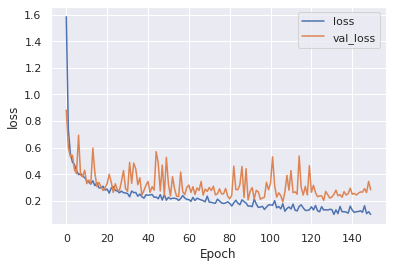

In [58]:
val_loss, val_acc = model.evaluate(val_data,  val_labels, verbose=2)

print('\nTest accuracy:', val_acc)

plot_loss(history)

### Evaluation of the model with Test data

In [59]:
test_loss, test_acc = model.evaluate(test_data,  test_labels, verbose=2)

print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

44/44 - 0s - loss: 0.2963 - accuracy: 0.9029 - 84ms/epoch - 2ms/step

Test loss: 0.2962760329246521

Test accuracy: 0.9028571248054504


In [60]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_data)
predictions[45]

44/44 [==============================] - 0s 1ms/step


array([3.4931574e-03, 9.9650687e-01, 9.5358427e-14, 6.7504596e-28,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 4.8797265e-38, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [61]:
from sklearn import metrics
print(metrics.classification_report(test_labels, predictions.argmax(axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.979     0.987     0.983       381
           1      0.950     0.938     0.944       242
           2      0.929     0.883     0.905       162
           3      0.836     0.953     0.891       128
           4      0.812     0.867     0.839       105
           5      0.789     0.737     0.762        76
           6      0.811     0.741     0.775        58
           7      0.766     0.706     0.735        51
           8      0.737     0.737     0.737        38
           9      0.793     0.821     0.807        28
          10      0.724     0.808     0.764        26
          11      1.000     0.933     0.966       105

    accuracy                          0.903      1400
   macro avg      0.844     0.843     0.842      1400
weighted avg      0.904     0.903     0.903      1400



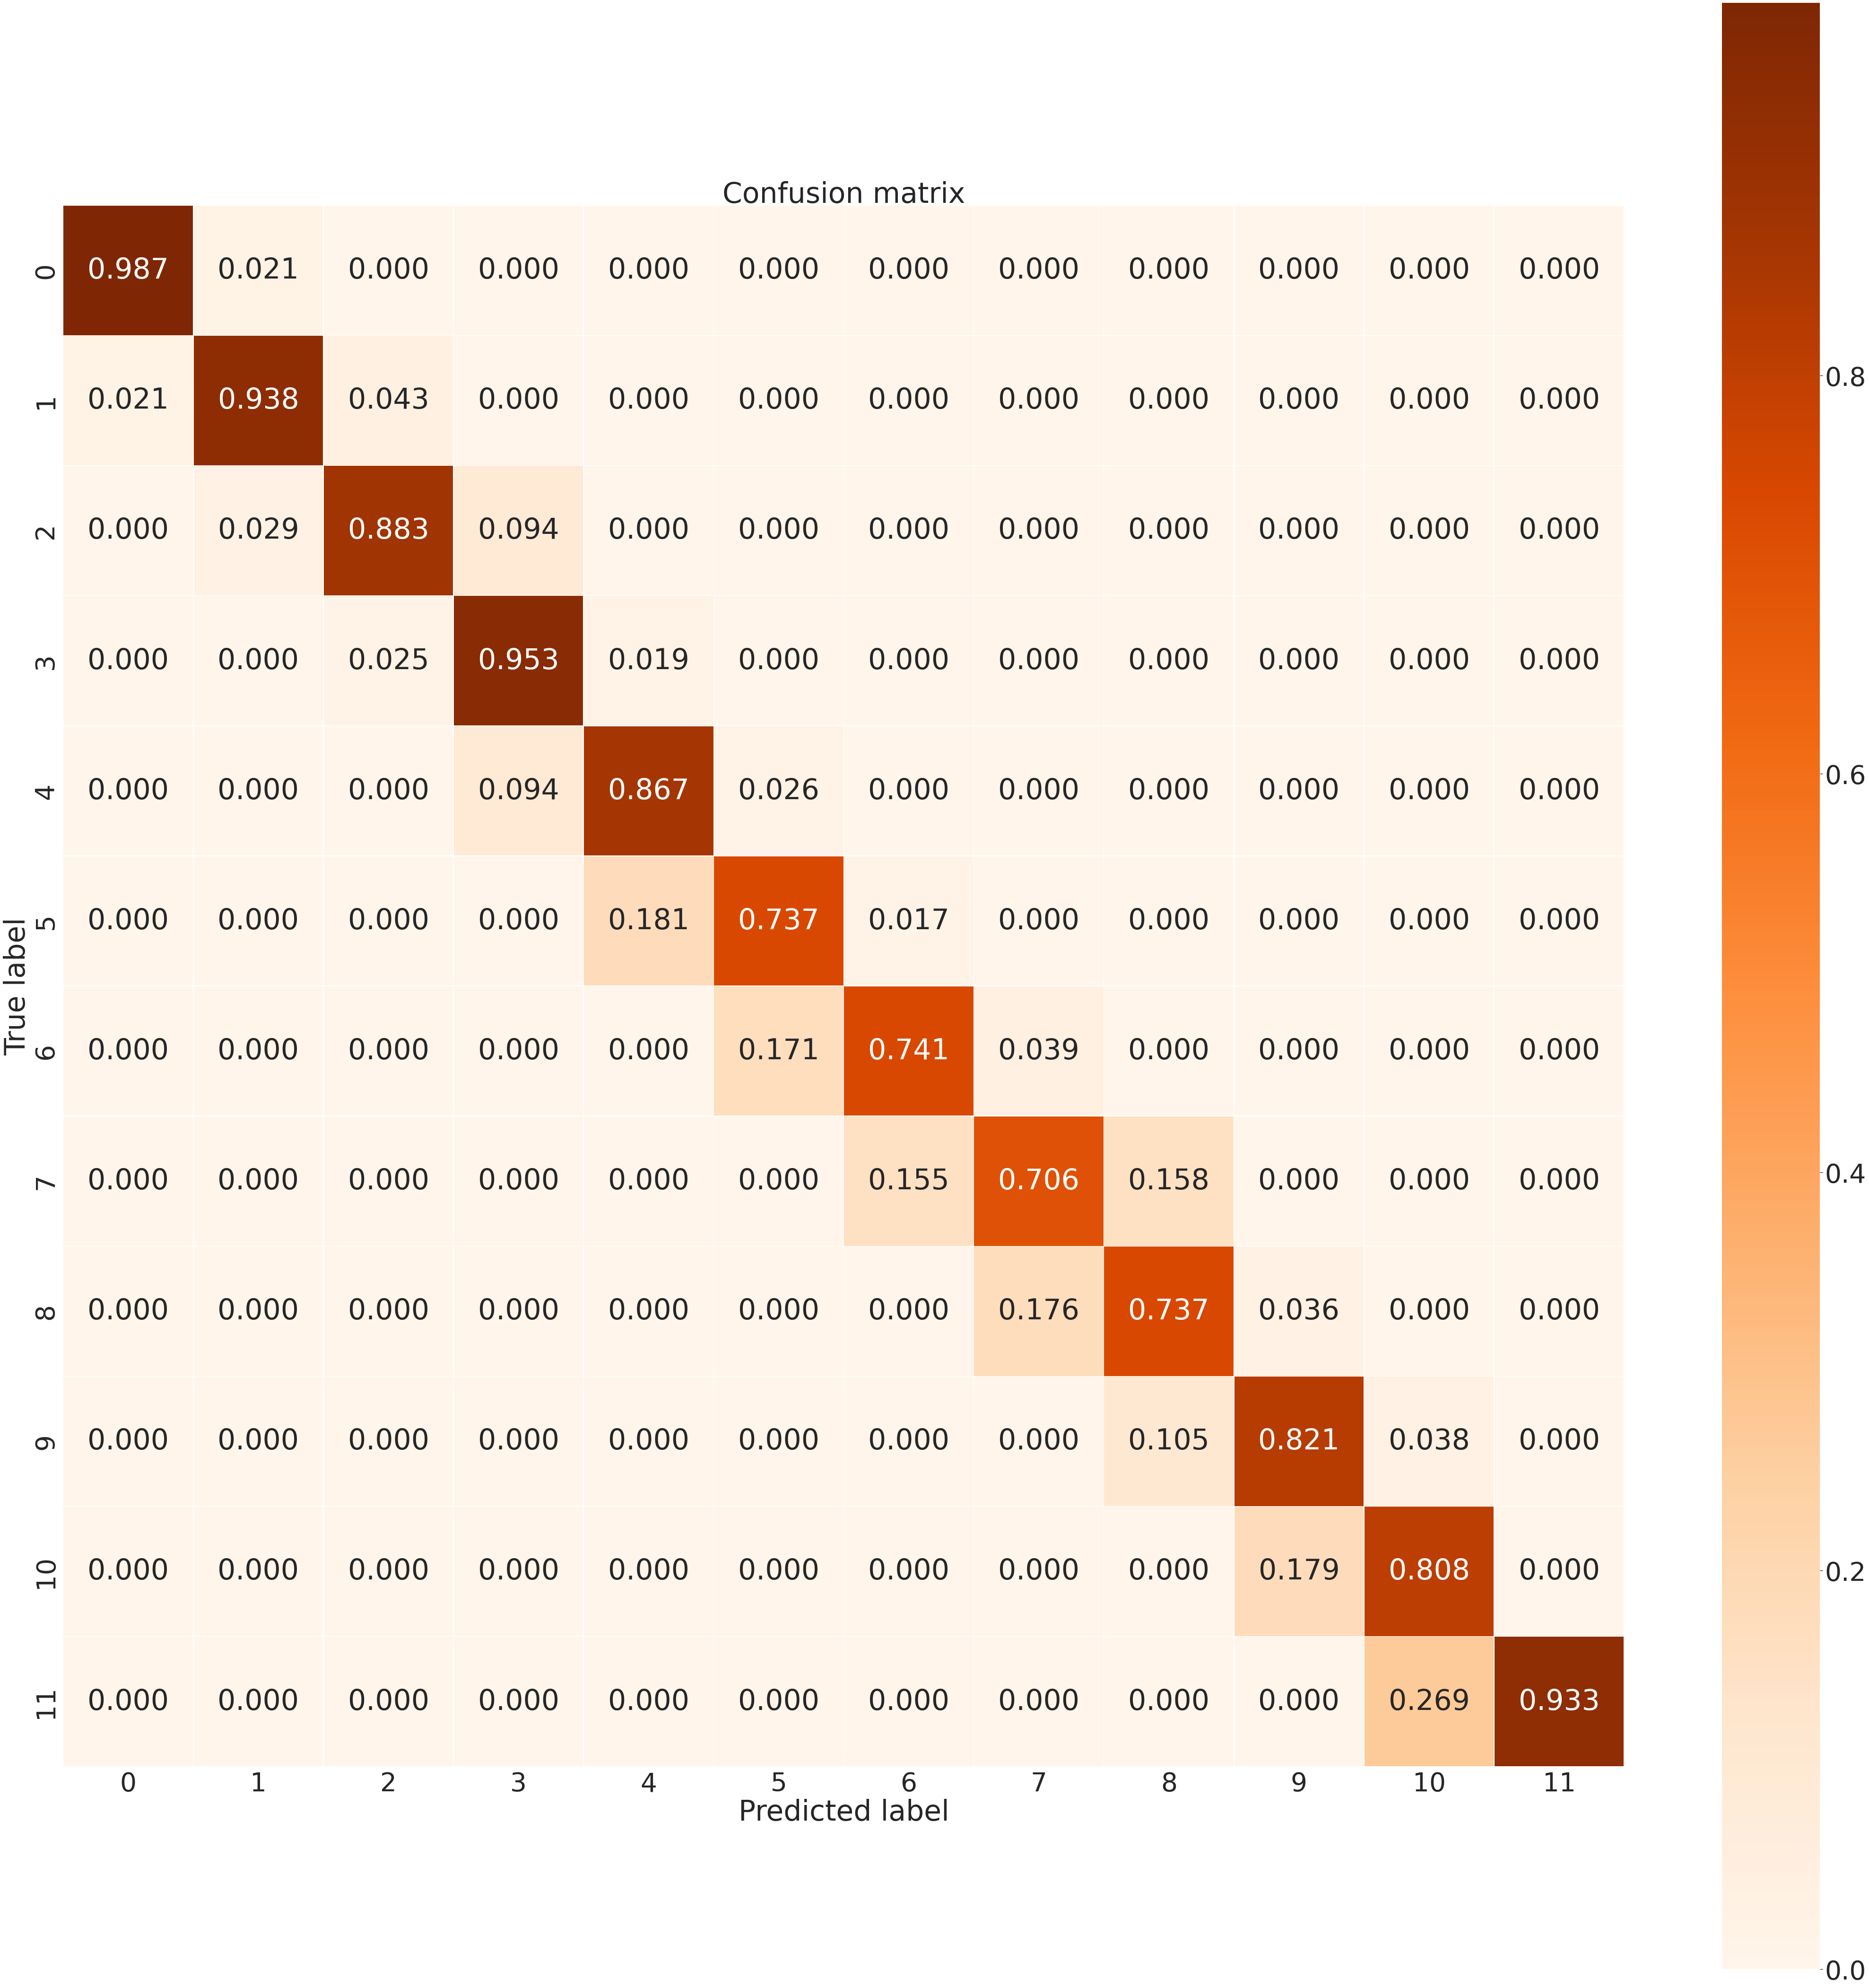

In [62]:
# Confusion matrix

matrix = metrics.confusion_matrix(test_labels.values, predictions.argmax(axis=1))
cmn = matrix / matrix.astype(float).sum(axis=1)

#correlation map
sns.set(font_scale=Font_scale)
f,ax=plt.subplots(figsize=Figsize)

sns.heatmap(cmn, annot=True, linewidths=.5, fmt='.3f', 
            #  mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=plt.cm.Oranges, 
             square=True, ax=ax)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')

plt.show()


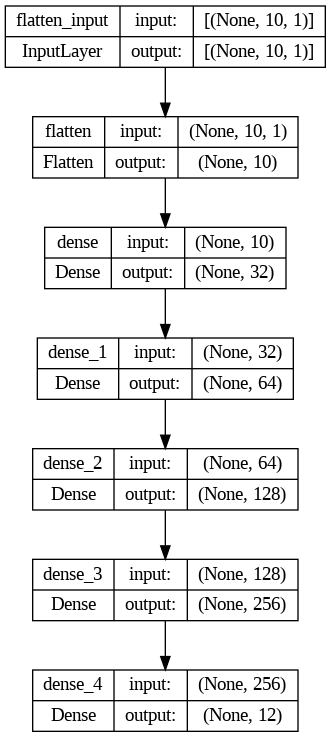

In [63]:
# Plot the model to visualize the network
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [64]:
for i in range(15):
  print('motor n.', i ,' ->',test_labels.values[i],' predicted->',np.argmax(predictions[i]))
print('motor n.', 45   ,' ->',test_labels.values[45],' predicted->',np.argmax(predictions[45]))

motor n. 0  -> 2  predicted-> 2
motor n. 1  -> 0  predicted-> 0
motor n. 2  -> 11  predicted-> 11
motor n. 3  -> 7  predicted-> 6
motor n. 4  -> 1  predicted-> 1
motor n. 5  -> 8  predicted-> 8
motor n. 6  -> 0  predicted-> 0
motor n. 7  -> 0  predicted-> 0
motor n. 8  -> 1  predicted-> 1
motor n. 9  -> 3  predicted-> 3
motor n. 10  -> 5  predicted-> 4
motor n. 11  -> 3  predicted-> 3
motor n. 12  -> 0  predicted-> 0
motor n. 13  -> 1  predicted-> 1
motor n. 14  -> 2  predicted-> 1
motor n. 45  -> 1  predicted-> 1


Multi Class classification outperforms regression models. More info in the report.

################################################################################
#### Analytical function analysis
Analytical function to predict demagnetization is analyzed.

To compare the test labels, we need to make the function result an integer. To make the result more clear, it was also clipped. Rounding methods used:
- Nearest (round)
- Floor
- Ceil

In [65]:
# init analytical analisis
from sklearn import metrics
predictions_analytical_round = np.clip(np.around(predictions_analytical.tolist(), 0), 0, 11)
predictions_analytical_floor = np.clip(np.floor(predictions_analytical.tolist()), 0, 11)
predictions_analytical_ceil = np.clip(np.ceil(predictions_analytical.tolist()), 0, 11)
test_labels_analytical = test_labels_analytical.tolist()

              precision    recall  f1-score   support

           0      0.896     0.604     0.722      1903
           1      0.567     0.822     0.671      1211
           2      0.883     0.780     0.828       812
           3      0.693     0.599     0.643       641
           4      0.459     0.411     0.433       526
           5      0.244     0.263     0.253       380
           6      0.184     0.201     0.192       289
           7      0.112     0.117     0.115       257
           8      0.121     0.147     0.133       191
           9      0.105     0.144     0.122       139
          10      0.056     0.062     0.059       128
          11      0.749     0.948     0.837       523

    accuracy                          0.588      7000
   macro avg      0.422     0.425     0.417      7000
weighted avg      0.629     0.588     0.595      7000



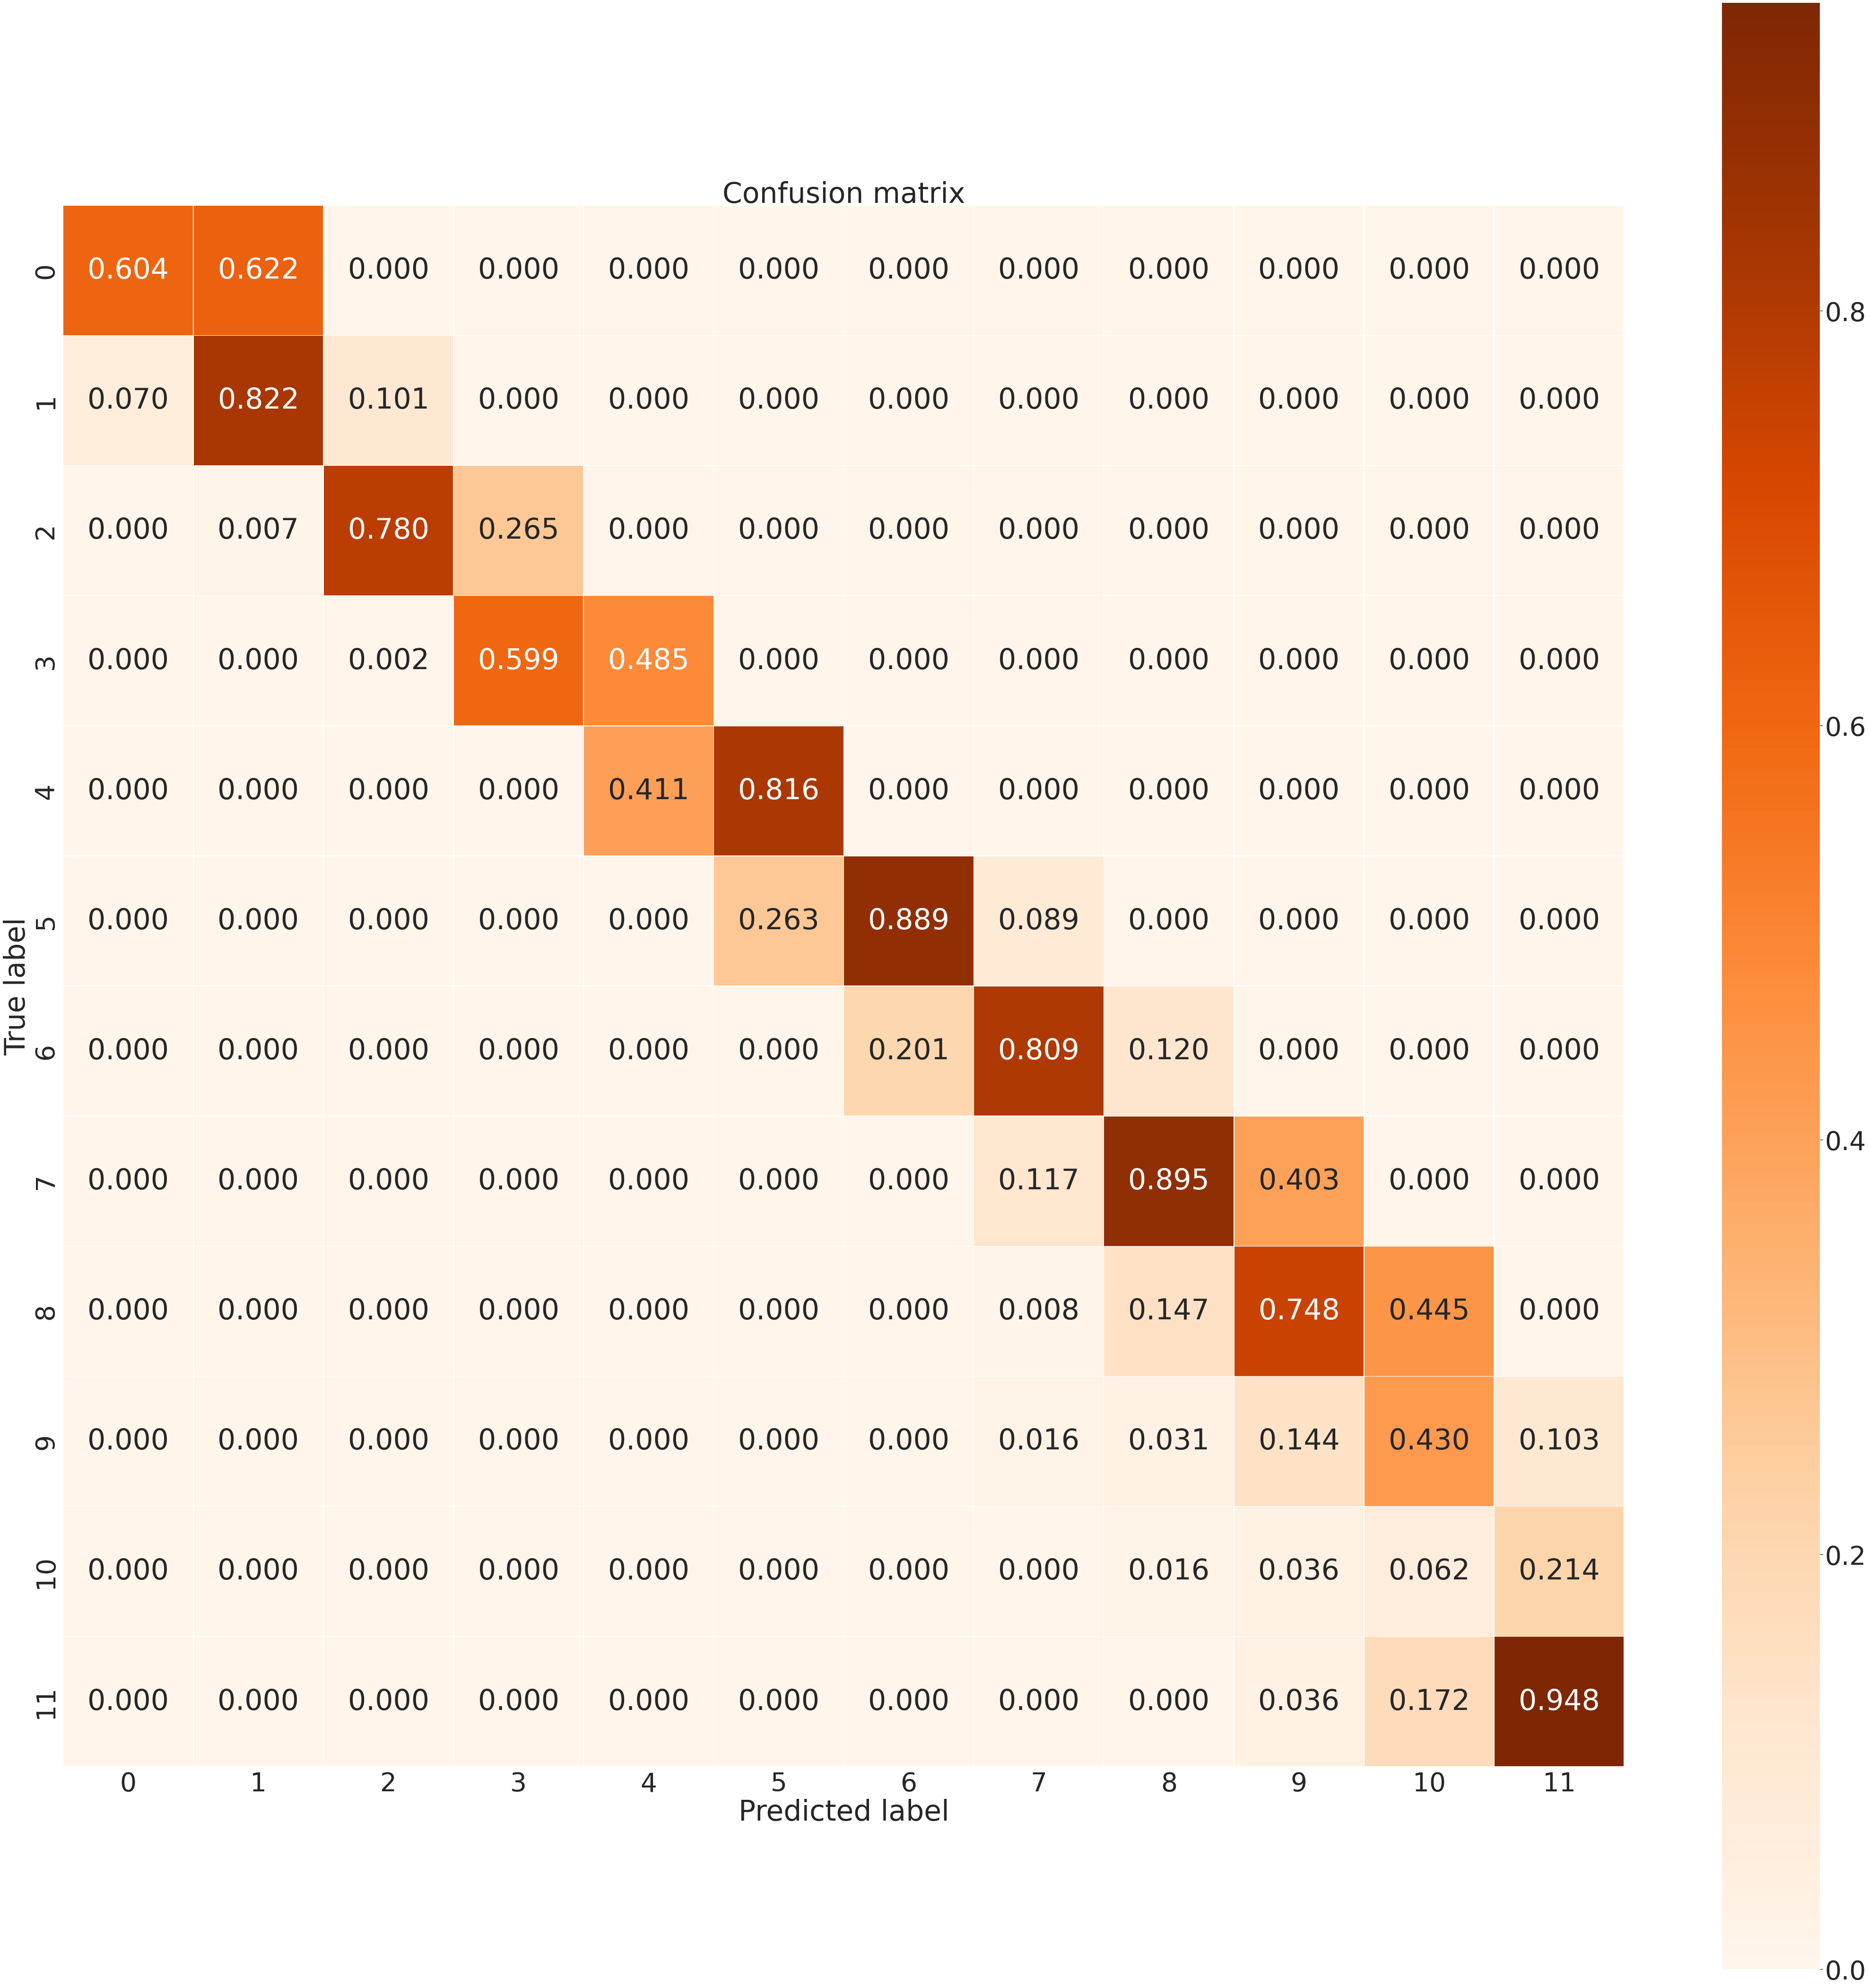

In [66]:
# Analytical results RONUD

print(metrics.classification_report(test_labels_analytical,predictions_analytical_round, digits=3,zero_division=0))

# Confusion matrix
matrix = metrics.confusion_matrix(test_labels_analytical, predictions_analytical_round)
cmn = matrix / matrix.astype(float).sum(axis=1)
#correlation map
f,ax=plt.subplots(figsize=Figsize)

sns.heatmap(cmn, annot=True, linewidths=.5, fmt='.3f', 
            #  mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=plt.cm.Oranges, 
             square=True, ax=ax)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
sns.set(font_scale=Font_scale)

plt.show()

              precision    recall  f1-score   support

           0      0.000     0.000     0.000      1903
           1      0.278     0.546     0.369      1211
           2      0.301     0.392     0.340       812
           3      0.185     0.175     0.180       641
           4      0.055     0.055     0.055       526
           5      0.027     0.032     0.029       380
           6      0.011     0.014     0.012       289
           7      0.011     0.012     0.011       257
           8      0.060     0.073     0.066       191
           9      0.054     0.086     0.066       139
          10      0.037     0.047     0.041       128
          11      0.695     0.971     0.810       523

    accuracy                          0.240      7000
   macro avg      0.143     0.200     0.165      7000
weighted avg      0.162     0.240     0.191      7000



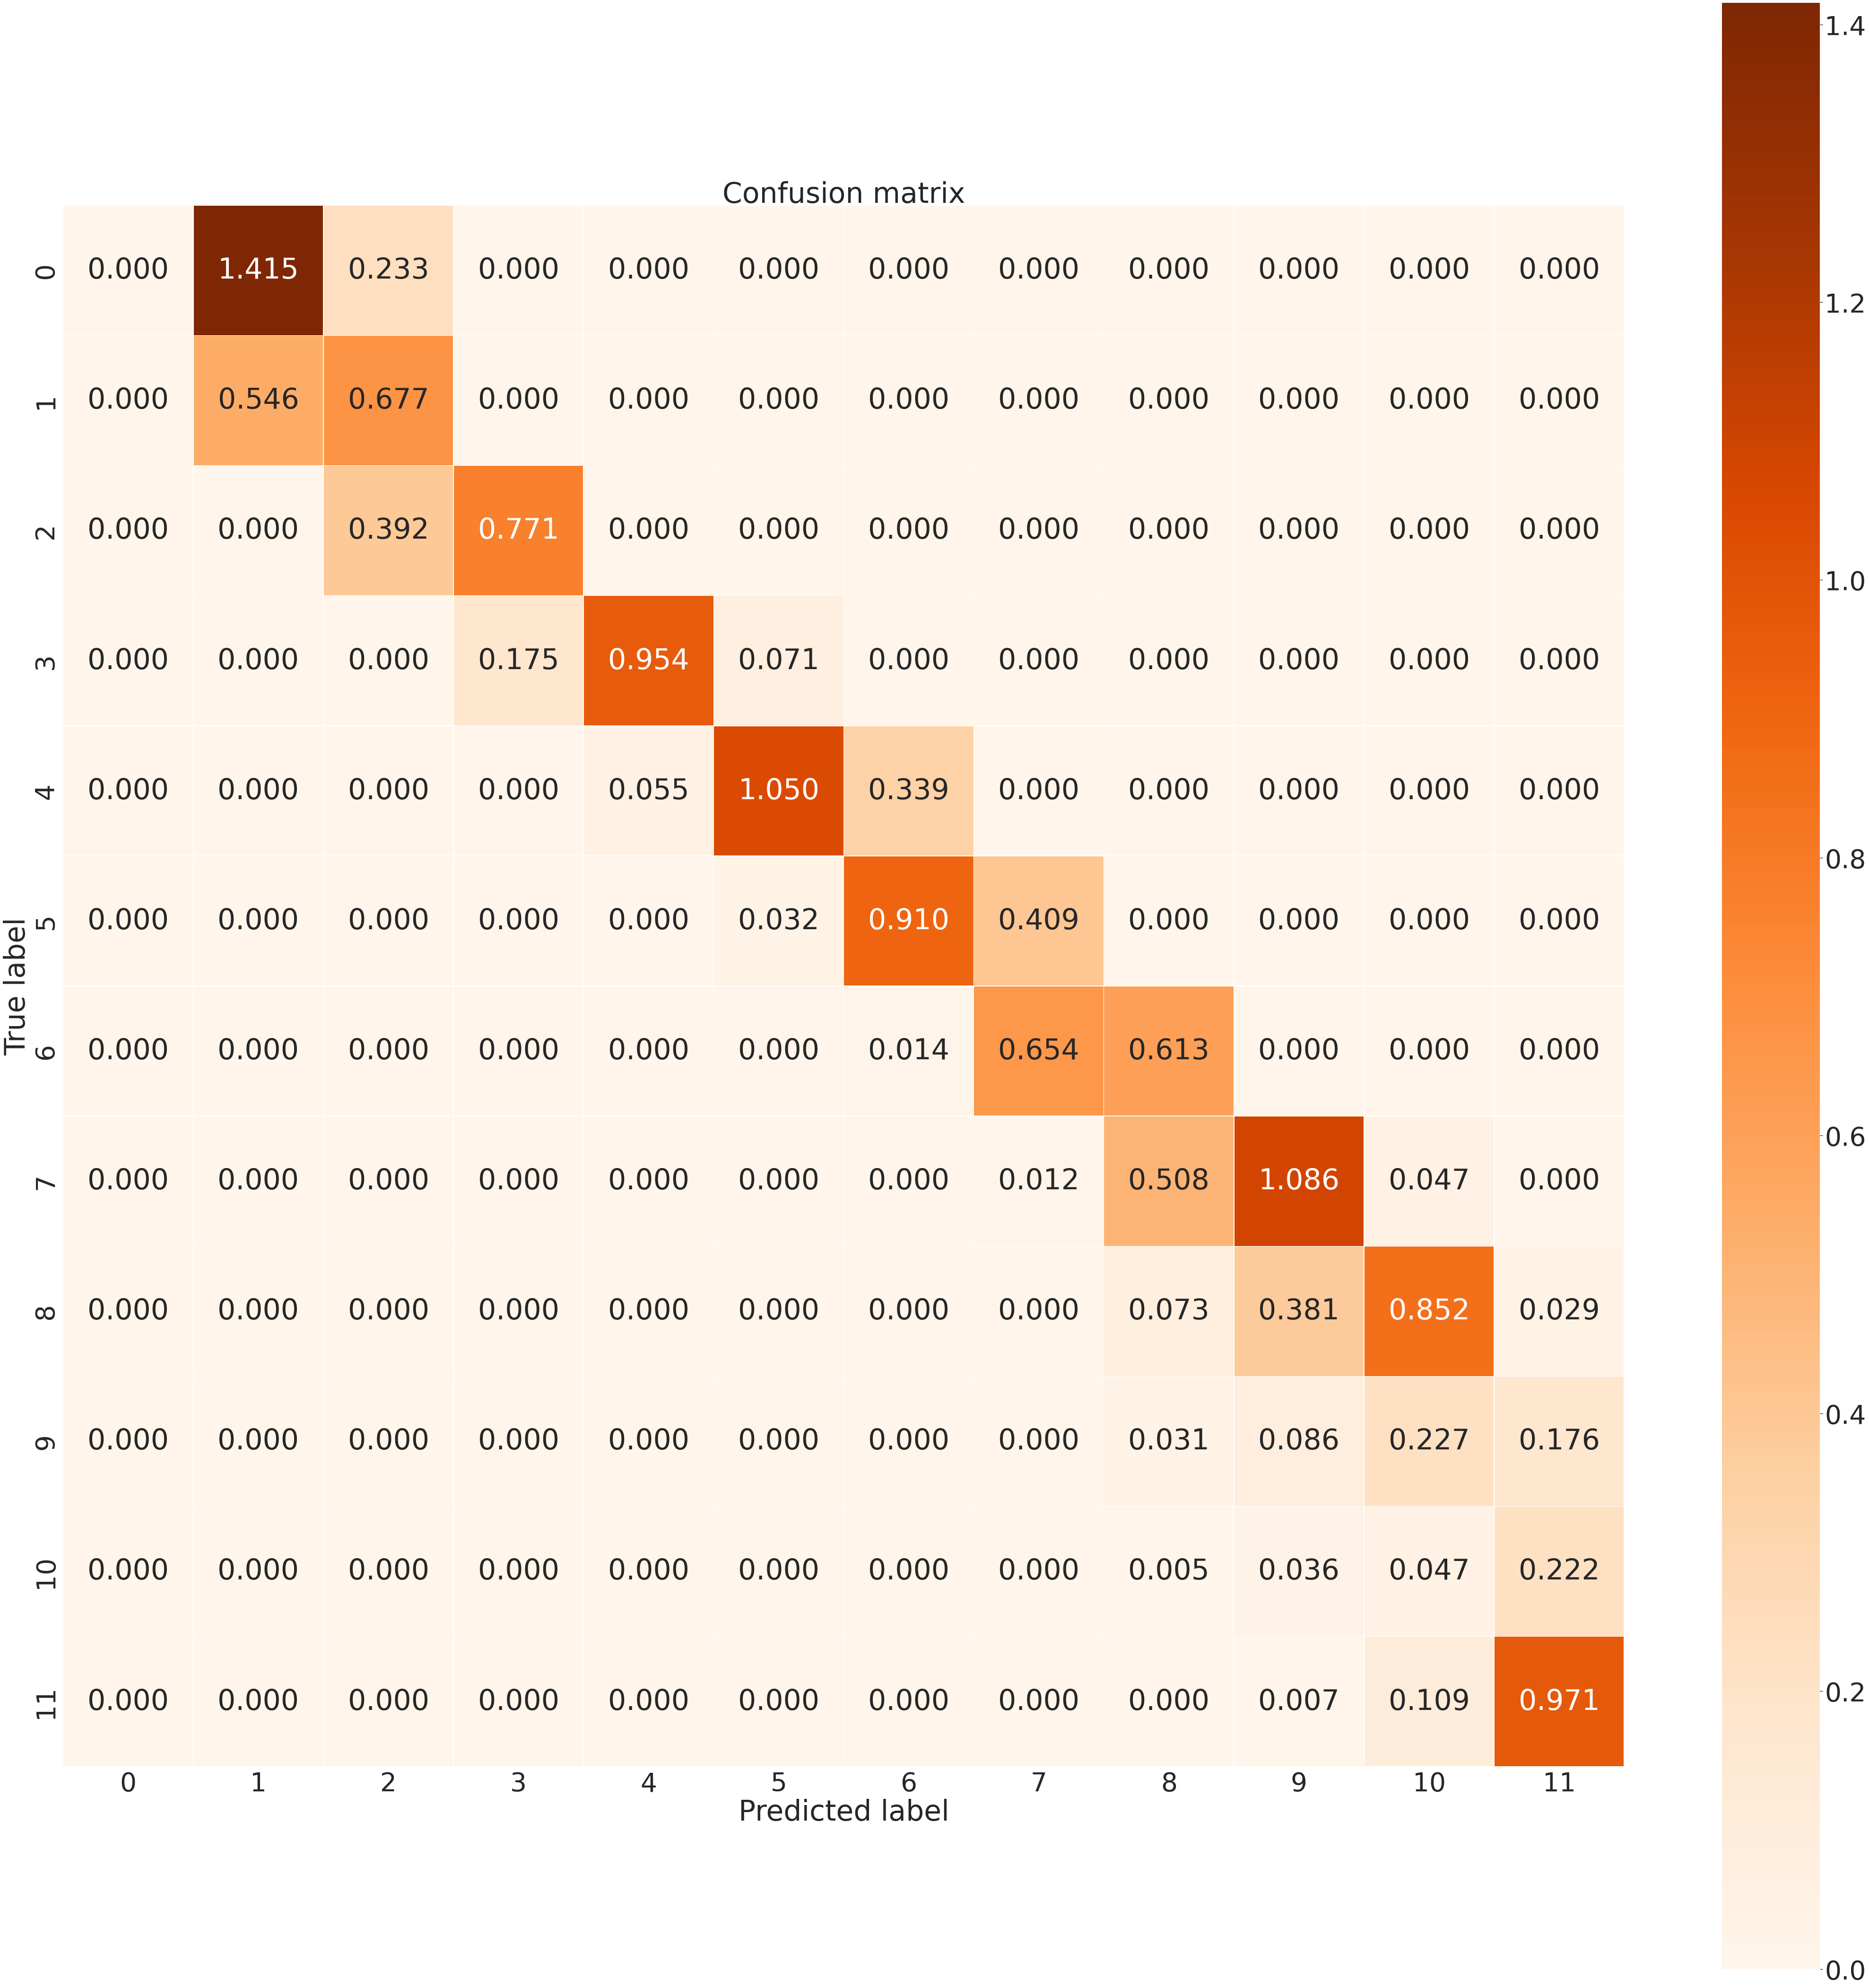

In [67]:
# Analytical results CEIL

print(metrics.classification_report(test_labels_analytical,predictions_analytical_ceil, digits=3,zero_division=0))

# Confusion matrix
matrix = metrics.confusion_matrix(test_labels_analytical, predictions_analytical_ceil)
cmn = matrix / matrix.astype(float).sum(axis=1)
#correlation map
f,ax=plt.subplots(figsize=Figsize)

sns.heatmap(cmn, annot=True, linewidths=.5, fmt='.3f', 
            #  mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=plt.cm.Oranges, 
             square=True, ax=ax)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
sns.set(font_scale=Font_scale)

plt.show()

              precision    recall  f1-score   support

           0      0.722     0.901     0.801      1903
           1      0.520     0.454     0.485      1211
           2      0.815     0.608     0.697       812
           3      0.945     0.783     0.857       641
           4      0.911     0.759     0.828       526
           5      0.721     0.692     0.706       380
           6      0.609     0.581     0.595       289
           7      0.413     0.377     0.394       257
           8      0.239     0.277     0.257       191
           9      0.177     0.209     0.191       139
          10      0.261     0.281     0.271       128
          11      0.826     0.937     0.878       523

    accuracy                          0.685      7000
   macro avg      0.597     0.572     0.580      7000
weighted avg      0.692     0.685     0.682      7000



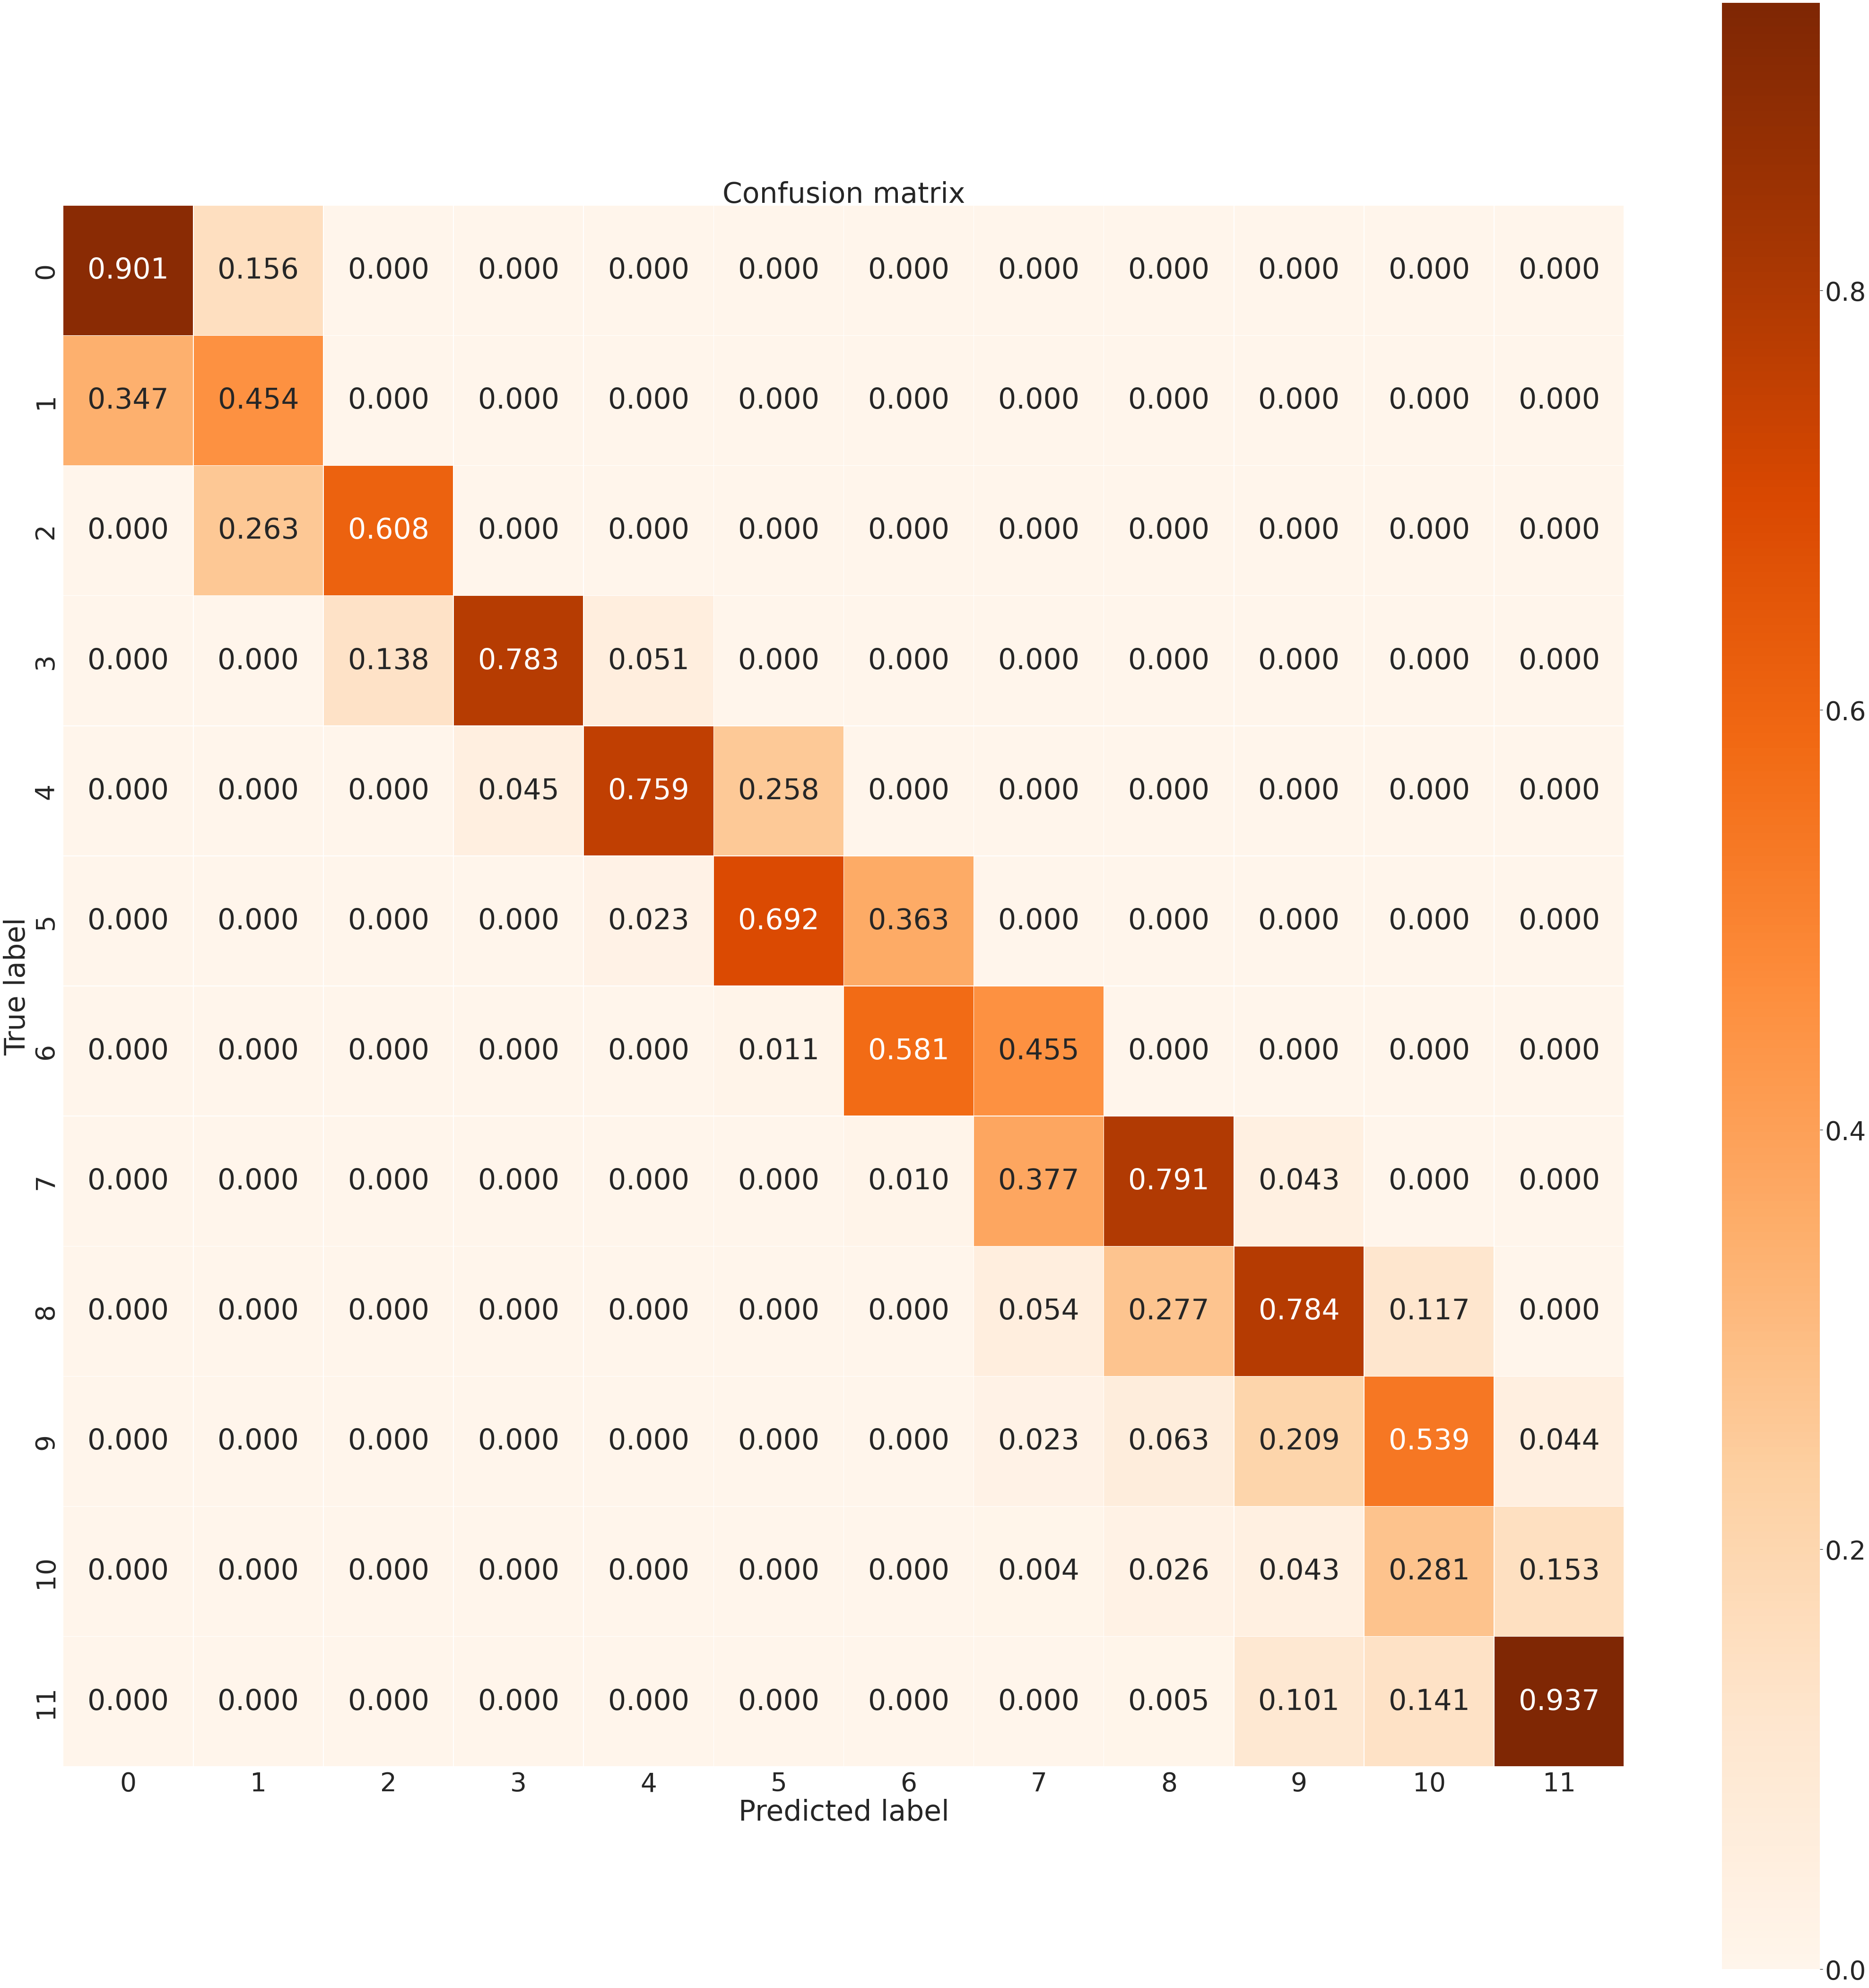

In [68]:
# Analytical results FLOOR

print(metrics.classification_report(test_labels_analytical,predictions_analytical_floor, digits=3,zero_division=0))

# Confusion matrix
matrix = metrics.confusion_matrix(test_labels_analytical, predictions_analytical_floor)
cmn = matrix / matrix.astype(float).sum(axis=1)
#correlation map
f,ax=plt.subplots(figsize=Figsize)

sns.heatmap(cmn, annot=True, linewidths=.5, fmt='.3f', 
            #  mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=plt.cm.Oranges, 
             square=True, ax=ax)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
sns.set(font_scale=Font_scale)

plt.show()